In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import time
from collections import namedtuple

## Utils

In [47]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def prepare_state(obs, last_action, last_rew, time_elapsed, rollout, rew_signal, args):
    obs_t = torch.FloatTensor(obs.flatten()).to(args['NN']['device'])
    last_action_t = torch.FloatTensor(last_action).to(args['NN']['device'])
    last_rew_t = torch.FloatTensor([last_rew]).to(args['NN']['device'])
    time_elapsed_t = torch.FloatTensor([time_elapsed]).to(args['NN']['device'])
    rollout_t = torch.FloatTensor(rollout.flatten()).to(args['NN']['device'])
    rew_signal_t = torch.FloatTensor([rew_signal]).to(args['NN']['device'])
    state = torch.cat([obs_t, last_action_t, last_rew_t, time_elapsed_t, rollout_t, rew_signal_t]).unsqueeze(0)
    return state

def simulation(net, obs, time_elapsed, env, args, max=False):
    h_in = torch.zeros([1, args['NN']['mem_size']])
    c_in = torch.zeros([1, args['NN']['mem_size']]) 
    counter = 0
    rew_signal = 0
    last_action = [0,0,0,0,1]
    rollout = np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']])
    while (counter < args['Env']['rollout_size']) and (rew_signal==0):
        state = prepare_state(obs=obs, 
                              last_action=last_action, 
                              last_rew=0, 
                              time_elapsed=time_elapsed, 
                              rollout=np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']]), 
                              rew_signal=rew_signal,
                              args=args)
        #return state, h_in, c_in
        with torch.no_grad():
            pi, v, h_in, c_in = net(state, h_in, c_in, True)
            if max:
                action = pi.argmax().item()
            else:
                prob = Categorical(pi.squeeze())
                action = prob.sample().item() 
            obs, _, _, info = env.step(action + 4)
            obs = obs[1]
            last_action = np.eye(5)[action]
            rollout[counter, action] = 1
            counter += 1
            rew_signal = info['rew_signal']
    return rollout, rew_signal

## Agent

In [48]:
class ACModel(nn.Module):
    def __init__(self, input_dim, action_dim, mem_out_size=128, activation=nn.ReLU()):
        super(ACModel, self).__init__()  

        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            activation
        ) 
        
        self.memory = nn.LSTM(64, mem_out_size)

        self.fc_pi = nn.Sequential(
            nn.Linear(mem_out_size, 32),
            activation,
            nn.Linear(32, action_dim + 1)
        )
        
        self.fc_v = nn.Sequential(
            nn.Linear(mem_out_size, 32),
            activation,
            nn.Linear(32, 1)
        )
               
    def forward(self, *args):
        x = args[0]
        h_in, c_in = args[-3:-1]
        simulation = args[-1]

        x = self.fc(x)
        out, (h_out, c_out) = self.memory(x, (h_in, c_in))
        
        # Value
        v = self.fc_v(out)
        # Policy 
        pi = self.fc_pi(out)
        if not simulation:
            pi = F.softmax(pi, dim=1)
        else:
            pi = F.softmax(pi[:, :-1], dim=1)
        return pi, v, h_out, c_out

## Environment

In [49]:
class Maze(object):
    def __init__(self, n_rows: int, n_cols: int, sigma: int=1, step_rew: int=0, goal_rew: int=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.sigma = sigma
        self.step_rew = step_rew
        self.goal_rew = goal_rew
        self.not_initialized = True
        self.all_pos = np.array(np.meshgrid(range(self.n_rows), range(self.n_cols))).T.reshape(-1, 2)
        self.deltas = {0: np.array([-1, 0]),
                       1: np.array([0, 1]), 
                       2: np.array([1, 0]),
                       3: np.array([0, -1])}

    def reset(self, change_init_pos: bool=False):
        self.done = False
        info = {'rew_signal': 0}
        if change_init_pos or self.not_initialized:
            self.not_initialized = False
            self.agent_pos = self.get_pos()
            self.agent_init_pos = self.agent_pos.copy()
            self.agent_simulated_pos = self.agent_pos.copy()
            self.goal_pos = self.set_goal_pos()
        else:
            self.agent_pos = self.agent_init_pos
        return (self.get_rbf(simulation=False), self.get_rbf(simulation=True)), self.step_rew, self.done, info

    def step(self, action: int):
        assert not self.done 
        self.update_agent_pos(action)
        info = {'rew_signal': 0}
        rew = self.step_rew 
        if np.all(self.agent_pos == self.goal_pos):
            rew = self.goal_rew
            info['rew_signal'] = 1
            self.done = True
        if np.all(self.agent_simulated_pos == self.goal_pos):
            info['rew_signal'] = 1
        return (self.get_rbf(simulation=False), self.get_rbf(simulation=True)), rew, self.done, info
    
    def get_pos(self):
        col = np.random.randint(0, self.n_cols)
        row = np.random.randint(0, self.n_rows)
        return np.array([col, row])
        
    def set_goal_pos(self):
        pos = self.get_pos()
        while np.all(pos == self.agent_pos):
            pos = self.get_pos()
        return pos
    
    def get_rbf(self, simulation: bool=False):
        if simulation:
            pos = self.agent_simulated_pos
        else:
            pos = self.agent_pos
        return np.exp(-np.sum((pos - self.all_pos)**2, 1)/self.sigma**2).reshape(self.n_cols, self.n_rows)

    def get_next_pos(self, pos, action):
        min_vals = np.array([0,0])
        max_vals = np.array([self.n_rows-1, self.n_cols-1]) 
        delta = self.deltas[action]  
        next_pos = np.clip(pos + delta, min_vals, max_vals)
        return next_pos

    def update_agent_pos(self, action: int):
        if action < 4:
            self.agent_pos = self.get_next_pos(self.agent_pos, action)
            self.agent_simulated_pos = self.agent_pos.copy()
        else:
            self.agent_simulated_pos = self.get_next_pos(self.agent_simulated_pos, action-4)

In [172]:
args = {
    'Env':{
        'n_actions': 4,
        'delta_time': 0.1,
        'rollout_size': 8,
        'n_cols': 5,
        'n_rows': 5
    },
    'Agent':{
        'gamma': 0.95,
        'lmbda': 0.95,
        'entropy_beta' : 0.1,
        'lr': 5e-5,
    },
    'NN': {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'activation_function': nn.Tanh(),
        'mem_size': 128
    }
}

args['Env']['n_states'] = (args['Env']['n_rows'] * args['Env']['n_cols'])
args['NN']['input_size'] = (args['Env']['n_states'] + args['Env']['n_actions'] + 1 + 2 + 
                            args['Env']['rollout_size'] * args['Env']['n_actions'] + 1)

args

{'Env': {'n_actions': 4,
  'delta_time': 0.1,
  'rollout_size': 8,
  'n_cols': 5,
  'n_rows': 5,
  'n_states': 25},
 'Agent': {'gamma': 0.95, 'lmbda': 0.95, 'entropy_beta': 0.1, 'lr': 5e-05},
 'NN': {'device': 'cpu',
  'activation_function': Tanh(),
  'mem_size': 128,
  'input_size': 65}}

In [173]:
env = Maze(args['Env']['n_cols'], args['Env']['n_rows'], sigma=4)

Agent pos: [4 1]
Goal pos: [4 4]


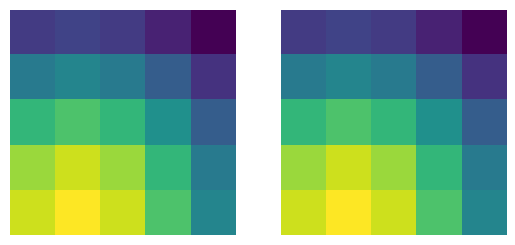

In [174]:
obs, rew, done, info = env.reset(change_init_pos=True)
print('Agent pos:', env.agent_init_pos)
print('Goal pos:', env.goal_pos)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(obs[0])
axs[1].imshow(obs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()


In [175]:
state = prepare_state(obs=obs[0], last_action=[0,0,0,0,0], last_rew=0, time_elapsed=0.4, 
                      rollout=np.zeros([8, 4]), rew_signal=1, args=args)
h_in = torch.zeros([1, args['NN']['mem_size']])
c_in = torch.zeros([1, args['NN']['mem_size']])
print(state.shape)

torch.Size([1, 65])


In [176]:
net = ACModel(args['NN']['input_size'], args['Env']['n_actions'], 
              mem_out_size=args['NN']['mem_size'], activation=args['NN']['activation_function'])
optimizer = optimizer = optim.Adam(net.parameters(), lr=args['Agent']['lr'])
net

ACModel(
  (fc): Sequential(
    (0): Linear(in_features=65, out_features=64, bias=True)
    (1): Tanh()
  )
  (memory): LSTM(64, 128)
  (fc_pi): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
  (fc_v): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [177]:
with torch.no_grad():
    pi, v, h_out, c_out = net(state, h_in, c_in, True)
print(pi.shape)
print(v.shape)
print(h_out.shape)
print(c_out.shape)

torch.Size([1, 4])
torch.Size([1, 1])
torch.Size([1, 128])
torch.Size([1, 128])


In [178]:
obs, rew, done_trial, info = env.reset(change_init_pos=True)
rollout, rew_signal = simulation(net, obs[1], 0, env, args)
print(rollout)
print(rew_signal)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
0


In [179]:
Trajectory = namedtuple('Trajectory',
                        ('action', 'reward', 'done', 'policy', 'value'))

In [180]:
def a2c_loss(buffer):
    batch = Trajectory(*zip(*buffer))
    vs_prime = torch.stack(batch.value[1:]).detach().squeeze()
    vs = torch.cat(batch.value[:-1])
    rews = np.array(batch.reward[:-1])
    pis = torch.cat(batch.policy[:-1])
    acts = np.stack(batch.action[:-1])
    done_mask = torch.FloatTensor(1-np.array(batch.done[:-1])).to(args['NN']['device'])
    td_target = (torch.FloatTensor(rews) + args['Agent']['gamma'] * vs_prime * done_mask.squeeze())
    delta = td_target - vs
    delta = delta.detach().cpu().numpy()
    advantage_lst = []
    advantage = 0.0
    for item in delta[::-1]:
        advantage = args['Agent']['gamma'] * args['Agent']['lmbda'] * advantage + item
        advantage_lst.append([advantage])
    advantage_lst.reverse()
    advantage = torch.FloatTensor(np.array(advantage_lst)).squeeze().to(args['NN']['device'])
    pi_a = pis.gather(1, torch.tensor(acts, dtype=torch.int64).to(args['NN']['device'])).squeeze() 

    # Actor Loss
    actor_loss = -(torch.log(pi_a) * advantage).mean()

    # Critic Loss
    critic_loss = F.smooth_l1_loss(vs.squeeze(), td_target.detach().squeeze())  
    
    # Entropy loss
    entropy = (torch.log(pis) * pis).sum(dim=1).mean()
    entropy_loss = args['Agent']['entropy_beta'] * entropy  

    loss = entropy_loss + critic_loss + actor_loss
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step() 

In [181]:
all_rews = []
sims_perc = []

In [384]:
start = time.time()
for episode in range(100000):
    buffer = []
    tot_rew = 0
    time_elapsed = 0
    obs, rew, done, info = env.reset(change_init_pos=True)
    simulations = 0
    number_steps = 0
    state = prepare_state(obs=obs[0], 
                          last_action=[0,0,0,0,0], 
                          last_rew=0, 
                          time_elapsed=time_elapsed, 
                          rollout=np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']]), 
                          rew_signal=0,
                          args=args)
    h_in = torch.zeros([1, args['NN']['mem_size']])
    c_in = torch.zeros([1, args['NN']['mem_size']])
    while not done:
        number_steps += 1
        pi, v, h_out, c_out = net(state, h_in, c_in, False)
        prob = Categorical(pi.squeeze())
        action = prob.sample().item()
        if action == 4:
            simulations += 1
            time_elapsed += 0.1*args['Env']['delta_time']
            rollout, rew_signal = simulation(net, obs[1], time_elapsed, env, args, True)
            rew = 0
            new_obs = obs
        else:
            time_elapsed += args['Env']['delta_time']
            new_obs, rew, done, info = env.step(action)
            rollout = np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']])
            rew_signal = info['rew_signal']
        action_one_hot = np.eye(5)[action]
        new_state = prepare_state(obs=new_obs[0], 
                                  last_action=action_one_hot, 
                                  last_rew=rew, 
                                  time_elapsed=time_elapsed, 
                                  rollout=rollout, 
                                  rew_signal=rew_signal,
                                  args=args)
        tot_rew += rew   
        if (time_elapsed >= 1) or done:
            done = True
        h_in, c_in = h_out, c_out
        obs = new_obs
        state = new_state   
        buffer += [Trajectory([action], rew, done, pi, v)] 
    _, v, _, _ = net(state, h_in, c_in, False)  
    buffer += [Trajectory(None, None, None, None, v)]  
    all_rews.append(tot_rew)
    sims_perc.append(simulations/number_steps)
    a2c_loss(buffer)

    if (episode % 100 == 0) and (episode > 0):
        print('Episode:', episode,
              ' -- Avg Rew:', np.round(np.mean(all_rews[-100:]), 3), 
              ' -- % simulation:', np.round(np.mean(sims_perc[-100:]), 3))
print('Total time:', time.time() - start)

Episode: 100  -- Avg Rew: 0.45  -- % simulation: 0.318
Episode: 200  -- Avg Rew: 0.51  -- % simulation: 0.293
Episode: 300  -- Avg Rew: 0.48  -- % simulation: 0.34
Episode: 400  -- Avg Rew: 0.6  -- % simulation: 0.267
Episode: 500  -- Avg Rew: 0.53  -- % simulation: 0.303
Episode: 600  -- Avg Rew: 0.58  -- % simulation: 0.277
Episode: 700  -- Avg Rew: 0.52  -- % simulation: 0.308
Episode: 800  -- Avg Rew: 0.65  -- % simulation: 0.272
Episode: 900  -- Avg Rew: 0.58  -- % simulation: 0.255
Episode: 1000  -- Avg Rew: 0.64  -- % simulation: 0.231
Episode: 1100  -- Avg Rew: 0.62  -- % simulation: 0.246
Episode: 1200  -- Avg Rew: 0.67  -- % simulation: 0.242
Episode: 1300  -- Avg Rew: 0.6  -- % simulation: 0.212
Episode: 1400  -- Avg Rew: 0.65  -- % simulation: 0.218
Episode: 1500  -- Avg Rew: 0.69  -- % simulation: 0.21
Episode: 1600  -- Avg Rew: 0.59  -- % simulation: 0.247
Episode: 1700  -- Avg Rew: 0.58  -- % simulation: 0.253
Episode: 1800  -- Avg Rew: 0.57  -- % simulation: 0.224
Episo

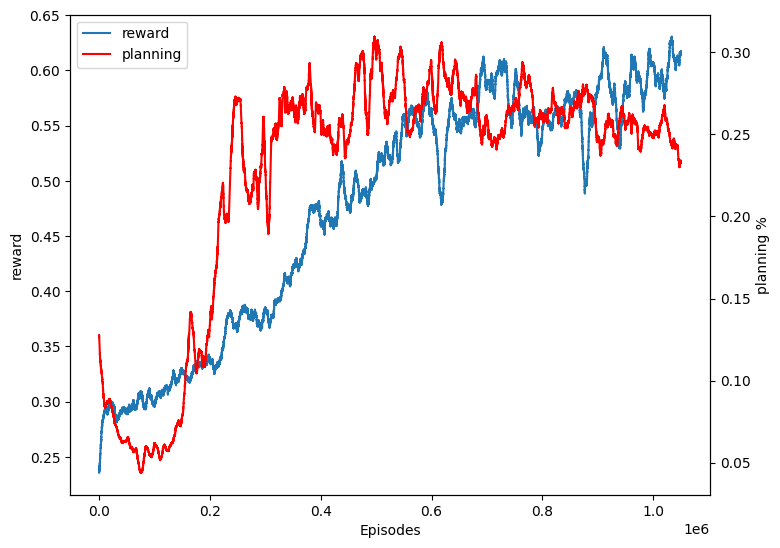

In [385]:
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
ax.set_ylabel('reward')
lns1 = ax.plot(moving_average(np.array(all_rews), 10000), label='reward')
ax2 = ax.twinx()
ax2.set_ylabel('planning %')
ax.set_xlabel('Episodes')
lns2 = ax2.plot(moving_average(np.array(sims_perc), 10000), color='red', label='planning')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.show()

In [435]:
np.savetxt("all_rews.txt", np.array(all_rews)) 
np.savetxt("sims_perc.txt", np.array(sims_perc)) 

In [433]:
checkpoint = { 
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(checkpoint, f'checkpoint.pt')

In [418]:
start = time.time()
data = []
for episode in range(1):
    tot_rew = 0
    time_elapsed = 0
    obs, rew, done, info = env.reset(change_init_pos=True)
    simulations = 0
    number_steps = 0
    state = prepare_state(obs=obs[0], 
                          last_action=[0,0,0,0,0], 
                          last_rew=0, 
                          time_elapsed=time_elapsed, 
                          rollout=np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']]), 
                          rew_signal=0,
                          args=args)
    h_in = torch.zeros([1, args['NN']['mem_size']])
    c_in = torch.zeros([1, args['NN']['mem_size']])
    while not done:
        number_steps += 1
        with torch.no_grad():
            pi, v, h_out, c_out = net(state, h_in, c_in, False)
        action = pi.argmax().item()
        if action == 4:
            simulations += 1
            time_elapsed += 0.1*args['Env']['delta_time']
            rollout, rew_signal = simulation(net, obs[1], time_elapsed, env, args, True)
            rew = 0
            new_obs = obs
        else:
            time_elapsed += args['Env']['delta_time']
            new_obs, rew, done, info = env.step(action)
            rollout = np.zeros([args['Env']['rollout_size'], args['Env']['n_actions']])
            rew_signal = info['rew_signal']
        data.append([action, rew_signal, rollout, pi])
        action_one_hot = np.eye(5)[action]
        new_state = prepare_state(obs=new_obs[0], 
                                  last_action=action_one_hot, 
                                  last_rew=rew, 
                                  time_elapsed=time_elapsed, 
                                  rollout=rollout, 
                                  rew_signal=rew_signal,
                                  args=args)
        tot_rew += rew   
        if (time_elapsed >= 1) or done:
            done = True
        h_in, c_in = h_out, c_out
        obs = new_obs
        state = new_state   
    print('Episode:', episode, ' -- Tot Rew:', tot_rew, ' -- % simulation:', simulations/number_steps)
print('Total time:', time.time() - start)

Episode: 0  -- Tot Rew: 1  -- % simulation: 0.1111111111111111
Total time: 0.014354944229125977


In [424]:
actions = np.array([x[0] for x in data])
rew_signals = np.array([x[1] for x in data])
rollouts = np.array([x[2] for x in data])
pis = [x[3] for x in data]

In [425]:
rew_signals

array([0, 0, 0, 0, 0, 1, 0, 0, 1])

In [426]:
rollouts[np.where((actions==4) & (rew_signals==1))[0][0]]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [427]:
actions

array([3, 3, 0, 0, 1, 4, 3, 3, 2])

In [432]:
np.round(np.array(torch.cat(pis)), 2)

array([[0.27, 0.08, 0.15, 0.47, 0.03],
       [0.32, 0.12, 0.14, 0.35, 0.07],
       [0.36, 0.13, 0.14, 0.27, 0.1 ],
       [0.35, 0.23, 0.05, 0.21, 0.15],
       [0.22, 0.39, 0.05, 0.19, 0.15],
       [0.3 , 0.12, 0.15, 0.04, 0.39],
       [0.05, 0.  , 0.15, 0.78, 0.02],
       [0.01, 0.  , 0.13, 0.86, 0.  ],
       [0.  , 0.  , 0.95, 0.02, 0.02]], dtype=float32)